In [1]:
pip install ipykernel

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install protobuf==3.20.*

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scipy-stack

In [3]:
pip install mlxtend

In [1]:
import numpy as np
from scipy import linalg
# seed = 232
# np.random.seed(seed)
input_path = "penelitian_tbc_3/"

In [2]:
import os
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Display total images avaible in train, val dan test sets
for _set in ['train','val','test']:
  n_normal = len(os.listdir(input_path +_set + '/normal'))
  n_infect = len(os.listdir(input_path +_set + '/tbc'))
  print('Set: {}, normal images: {}, tbc images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 196, tbc images: 196
Set: val, normal images: 65, tbc images: 65
Set: test, normal images: 65, tbc images: 65


In [5]:
#define some constants
img_dims = 224
batch_size = 4

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# image augmentations
image_gen = ImageDataGenerator(rescale=1./255
                               #validation_split=0.2
                               )

# flow_from_directory generators
train_generator = image_gen.flow_from_directory(
                  directory = input_path+'train',
                  target_size=(img_dims, img_dims),
                  class_mode="binary",
                  batch_size=batch_size,
                  #subset='training'
                  )

validation_generator = image_gen.flow_from_directory(
                  directory = input_path+'val',
                  target_size=(img_dims, img_dims),
                  class_mode="binary",
                  batch_size=batch_size,
                  #subset='validation'
                  )


Found 392 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [7]:
import efficientnet.keras as efn
from tensorflow.keras.callbacks import Callback
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
# from tensorflow.keras.metrics import Recall, Precision, Sensitivity, Specificity

# Callbacks
## Keep the best model
# mc = ModelCheckpoint('model.hdf5', 
                    #  save_best_only=True, 
                    #  verbose=0, 
                    #  monitor='val_loss', 
                    #  mode='min')

## Reduce learning rate if it gets stuck in a plateau
# rlr = ReduceLROnPlateau(monitor='val_loss', 
#                         factor=0.3, 
#                         patience=3, 
#                         min_lr=0.000001, 
#                         verbose=1)

# Model
## Define the base model with EfficientNet weights
model = tf.keras.applications.ResNet101(weights = 'imagenet', 
                           include_top = False, 
                           input_shape = (img_dims, img_dims, 3),
                           pooling='avg')

In [8]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
## Output layer
x = model.output
#x = GlobalAveragePooling2D()(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

## Compile and run
model = Model(inputs=model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,name="SGD"),
              loss='binary_crossentropy', 
              #metrics=['accuracy', Precision()])
              metrics=['accuracy'])

In [9]:
model_history = model.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=train_generator.n/batch_size,
                            validation_steps=validation_generator.n/batch_size,
                            epochs=200,
                            verbose=1)
                            # callbacks=[mc])
                            #, rlr])

Epoch 1/200
98/98 [==============================] - 25s 138ms/step - loss: 0.3285 - accuracy: 0.8444 - val_loss: 0.9489 - val_accuracy: 0.5000
Epoch 2/200
98/98 [==============================] - 12s 119ms/step - loss: 0.1225 - accuracy: 0.9464 - val_loss: 1.3525 - val_accuracy: 0.5000
Epoch 3/200
98/98 [==============================] - 12s 119ms/step - loss: 0.0606 - accuracy: 0.9745 - val_loss: 0.7403 - val_accuracy: 0.5462
Epoch 4/200
98/98 [==============================] - 12s 120ms/step - loss: 0.0363 - accuracy: 0.9872 - val_loss: 0.7122 - val_accuracy: 0.6077
Epoch 5/200
98/98 [==============================] - 12s 120ms/step - loss: 0.0336 - accuracy: 0.9847 - val_loss: 1.4394 - val_accuracy: 0.4923
Epoch 6/200
98/98 [==============================] - 12s 120ms/step - loss: 0.0134 - accuracy: 0.9949 - val_loss: 0.9142 - val_accuracy: 0.4538
Epoch 7/200
98/98 [==============================] - 12s 120ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.8740 - val_accuracy:

In [11]:
'''
kemudian kita convert datalog dari history model dalam bentuk file .csv
file ini dapat didownload di gdrive (akan muncul di tab kiri <<<<)
'''

import pandas as pd  
hist_df = pd.DataFrame(model_history.history) 

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [12]:
'''
model yang telah ditrain juga dapat disimpan dalam bentuk format .tflite dan .h5
file .tflite dapat kita benam kedalam smartphone
sedangkan file .h5 bisa kita gunakan kembali dengan function load model
'''

# save file to format .hdf5
model.save("model_resnet101.h5")

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Convert the model
tflite_model = converter.convert()

# Save to file
with open("model.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\LabData\AppData\Local\Temp\tmphbvcneea\assets


INFO:tensorflow:Assets written to: C:\Users\LabData\AppData\Local\Temp\tmphbvcneea\assets


<Figure size 432x288 with 0 Axes>

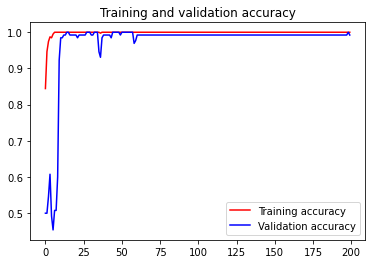

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot training and validation accuracy by epoch
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

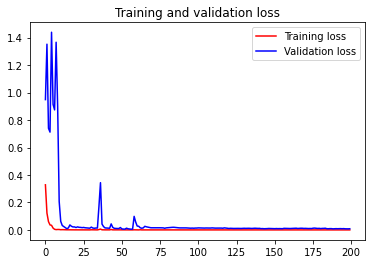

<Figure size 432x288 with 0 Axes>

In [14]:
# Plot training and validation accuracy by epoch
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)
                                    
test_generator = test_datagen.flow_from_directory(
    directory = input_path+"test",
    target_size=(img_dims, img_dims),
    class_mode="binary",
    shuffle=False,
    batch_size=batch_size
)

preds = model.predict_generator(generator=test_generator) # get proba predictions
labels = 1*(preds > 0.5) # convert proba to classes

Found 130 images belonging to 2 classes.


C:\Users\LabData\AppData\Local\Temp\ipykernel_2072\3648189458.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(generator=test_generator) # get proba predictions


In [16]:
model.evaluate(test_generator)

33/33 [==============================] - 1s 34ms/step - loss: 0.0309 - accuracy: 0.9923


[0.0308553297072649, 0.9923076629638672]

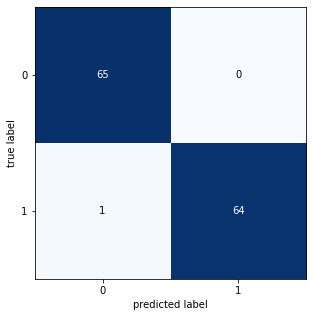

In [17]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
CM = confusion_matrix(test_generator.classes, labels)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [18]:
tn, fp, fn, tp = CM.ravel()
akurasi = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
print('accuracy:', akurasi)
print('sensitivity:', sensitivity)
print('specificity:', specificity)
print('precision:', precision)

accuracy: 0.9923076923076923
sensitivity: 0.9846153846153847
specificity: 1.0
precision: 1.0
